In [1]:
# Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import sys
from datetime import datetime
import random
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import cv2
# Sklearn
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
# Torch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
# TorchVision
from torchvision import models, transforms, datasets
from torchvision.utils import make_grid
# Timm
import timm
# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Hyperopt
from hyperopt import hp
from hyperopt import fmin, tpe

device = torch.device('cuda')

# ⚠️Seed everything!
It's important to seed everything for reproducibility.

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
seed = 42
seed_everything(seed)

# EDA

In [4]:
df_train = pd.read_csv('3md3070-dlmi/trainset/trainset_true.csv')
df_train['GENDER'] = df_train.GENDER.apply(lambda x: int(x=='F'))
df_train['DOB'] = df_train['DOB'].apply(lambda x: x.replace("-", "/"))
df_train['AGE'] = df_train['DOB'].apply(lambda x: 2020-int(x.split("/")[-1]))

In [5]:
# sns.pairplot(df_train[['LABEL', 'GENDER', 'LYMPH_COUNT', "AGE"]])

In [6]:
df_test = pd.read_csv('3md3070-dlmi/testset/testset_data.csv')
df_test['GENDER'] = df_test.GENDER.apply(lambda x: int(x=='F'))
df_test['DOB'] = df_test['DOB'].apply(lambda x: x.replace("-", "/"))
df_test['AGE'] = df_test['DOB'].apply(lambda x: 2020-int(x.split("/")[-1]))
df_test.head()

,ID,LABEL,GENDER,DOB,LYMPH_COUNT,AGE
0,P71,-1,0,1/17/1946,5.76,74
1,P16,-1,0,3/5/1940,32.00,80
2,P114,-1,0,6/16/1929,4.60,91
3,P170,-1,0,11/3/1933,4.80,87
4,P98,-1,1,5/14/1970,6.24,50


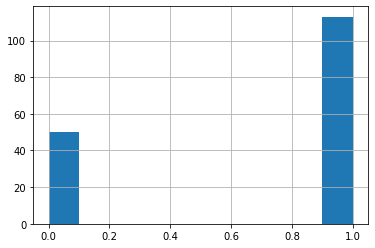

In [7]:
df_train.LABEL.hist()
plt.show()

In [8]:
def show_sample(group, shape=(5,2), figsize=(15,15)):
    total_samples = shape[0]*shape[1]
    nrow = shape[0]
    
    path_samples = random.sample(os.listdir(f'3md3070-dlmi/trainset/{group}'),total_samples)
    batch_tensor = []
    for path in path_samples:
        img = transforms.ToTensor()(Image.open(os.path.join(f'3md3070-dlmi/trainset/{group}', path)).convert("RGB")).unsqueeze(0)
        batch_tensor.append(img)
    batch_tensor = torch.cat(batch_tensor)
    grid_img = make_grid(batch_tensor, nrow=nrow)
    plt.figure(figsize=figsize)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

Showing 10 samples from P0


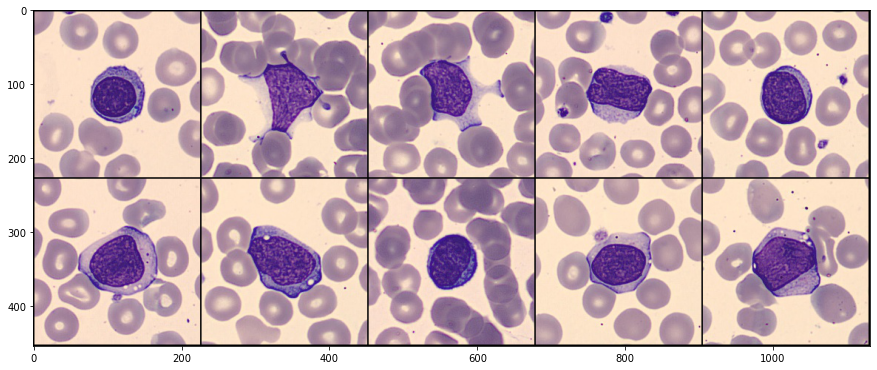

In [9]:
print("Showing 10 samples from P0")
show_sample("P0")

# Baselines
### Random Predictor
In this section we evaluate a random predictor on the training set

In [10]:
y_pred_random = []
for i in range(len(df_train)):
    y_pred_random.append(random.choice([0,1]))
print("Random predictor got", balanced_accuracy_score(df_train.LABEL, y_pred_random))

Random predictor got 0.5300884955752212


### Dummy Predictor

In this section we evaluate the performance of a dummy predictor that only outputs the most frequent label, 1 in this case on the training set.

In [11]:
y_pred_dummy = []
for i in range(len(df_train)):
    y_pred_dummy.append(1)
print("Dummy predictor got", balanced_accuracy_score(df_train.LABEL, y_pred_dummy))

Dummy predictor got 0.5


### LYMPH_COUNT Predictor
By looking at the dataset, we can see there's some correlation between the LYMPH_COUNT and the label. More specifically, the average value of the LYMPH_COUNT for 0 LABEL is 5 and for 1 is 35, so we'll empirically assign 0 to any bag with LYMPH_COUNT<=some_value and 1 otherwise

In [12]:
def lymph_count_predictor(thres=7):
    stratfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    split_scores = []
    for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
        X_train, X_val = df_train.LYMPH_COUNT[train_index].values.reshape(-1, 1), df_train.LYMPH_COUNT[test_index].values.reshape(-1, 1)
        y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
        y_pred = [int(x>thres) for x in X_val]
    #     print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))
        split_scores.append(balanced_accuracy_score(y_val, y_pred))
    return np.mean(split_scores)

In [13]:
print("Mean Balanced Accuracy",lymph_count_predictor(7.55))

Mean Balanced Accuracy 0.8573913043478261


Let's make a first submission with this baseline, we can probably get more just by making a linear regression, but let's try this simple approach first!

In [14]:
sub_dict = {"ID":df_test.ID.values, "Predicted": [int(df_test.iloc[i,4]>7) for i in range(len(df_test))]}
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub.to_csv('submission.csv')

This approach yields a score of 0.82337 on the public LB.

# Aggregating LYMPH COUNT and AGE
We saw how powerful the last approach was, what if we incorporate age too?

In [27]:
def age_lymph_predictor(space):
    age = space['age']
    lymph = space['lymph']
    aggregation = space['aggregation']
    stratfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    split_scores = []
    for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
        X_train, X_val = df_train[["AGE", "LYMPH_COUNT"]].values[train_index], df_train[["AGE", "LYMPH_COUNT"]].values[test_index]
        y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
        if aggregation == 'and':
            y_pred = [int((a>age) and int(b>lymph)) for (a,b) in X_val]
        elif aggregation == 'or':
            y_pred = [int((a>age) or int(b>lymph)) for (a,b) in X_val]
    #     print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))
        split_scores.append(balanced_accuracy_score(y_val, y_pred))
    return 1-np.mean(split_scores)

This time we will use Hyperopt in order to optimize hyperparameters for maximum effect!

In [48]:
space = {
    'age': hp.randint('age', 0, 100),
    'lymph': hp.normal('lymph', 7, 30),
    "aggregation": hp.choice('aggregation', ['and', 'or'])
}

In [49]:
best = fmin(age_lymph_predictor, space, algo=tpe.suggest, max_evals=10000)

100%|█████████████████████████████████████████| 10000/10000 [10:40<00:00, 15.62trial/s, best loss: 0.11924901185770742]


In [62]:
print("Best parameters found are age:{age}, aggregation: {aggregation}, lymph_count: {lymph}".format(**best))
print("The best score is", 1-age_lymph_predictor(best))

Best parameters found are age:55, aggregation: and, lymph_count: 7
The best score is 0.848498023715415


In [60]:
age = best['age']
lymph = best['lymph']
sub_dict = {"ID":df_test.ID.values, "Predicted": [int((df_test.iloc[i,5]>age) or int(df_test.iloc[i,4]>lymph)) for i in range(len(df_test))]}
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub.to_csv('submission.csv')

This approach yields a score of 0.74805 on the public LB

### Logistic Regression
Since the last approach seemed to work, let's try to apply a logistic regression on the LYMPH COUNT variable and AGE.

In [63]:
stratfold = StratifiedKFold(n_splits=5, shuffle=True)
split_scores = []
for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
    X_train, X_val = df_train[["LYMPH_COUNT", "AGE"]].values[train_index], df_train[["LYMPH_COUNT", "AGE"]].values[test_index]
    y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
    clf = LogisticRegression().fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))
    split_scores.append(balanced_accuracy_score(y_val, y_pred))
print("Mean Balanced Accuracy", np.mean(split_scores))

Balanced Accuracy Score 0.9130434782608696
Balanced Accuracy Score 0.7
Balanced Accuracy Score 0.8130434782608695
Balanced Accuracy Score 0.8545454545454545
Balanced Accuracy Score 0.8545454545454545
Mean Balanced Accuracy 0.8270355731225296


### RandomForestClassifier

The logistic regression doesn't seem to be suitable in this setting, let's try a more robust estimator: Random Forest

In [125]:
def rf_classifier(space):
    
    n_estimators = space['n_estimators']
    min_samples_leaf = space['min_samples_leaf']
    max_depth = space['max_depth']
    class_weight = space['class_weight']
    
    
    stratfold = StratifiedKFold(n_splits=5)
    split_scores = []
    for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
        X_train, X_val = df_train[["LYMPH_COUNT", "AGE", "GENDER"]].values[train_index], df_train[["LYMPH_COUNT", "AGE", "GENDER"]].values[test_index]
        y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
        clf = RandomForestClassifier(random_state=42, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth, class_weight=class_weight, n_jobs=-1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        split_scores.append(balanced_accuracy_score(y_val, y_pred))
    return 1-np.mean(split_scores)

In [126]:
space = {
    'n_estimators': hp.choice('n_estimators', [100+i*100 for i in range(10)]),
    #'min_samples_split ': hp.choice('min_samples_split', [2,5,10,15,50,100]),
    'min_samples_leaf' : hp.choice('min_samples_leaf',[1, 2, 5, 10]),
    'max_depth' : hp.choice('max_depth',[5, 8, 15, 25, 30]),
    'class_weight': hp.choice('class_weight', [None, "balanced"])
}
best = fmin(rf_classifier, space, algo=tpe.suggest, max_evals=500)

100%|█████████████████████████████████████████████| 500/500 [22:07<00:00,  2.65s/trial, best loss: 0.12347826086956515]


In [127]:
best

{'class_weight': 1, 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 0}

In [131]:
clf_rf = RandomForestClassifier(**{'n_estimators':100,'min_samples_leaf':10,'max_depth':25,'class_weight':'balanced'})
clf_rf.fit(df_train[["LYMPH_COUNT", "AGE", "GENDER"]], df_train.LABEL)
y_pred_rf =  clf_rf.predict(df_test[["LYMPH_COUNT", "AGE", "GENDER"]])

In [132]:
sub_dict = {"ID":df_test.ID.values, "Predicted": y_pred_rf}
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub.to_csv('submission.csv')

In [128]:
1-rf_classifier({'n_estimators':100,'min_samples_leaf':10,'max_depth':25,'class_weight':'balanced'})

0.8765217391304349

# Ensembling the baselines

In [65]:
stratfold = StratifiedKFold(n_splits=5, shuffle=True)
split_scores = []
for train_index, test_index in stratfold.split(df_train, df_train.LABEL):
    X_train, X_val = df_train[["LYMPH_COUNT", "AGE"]].values[train_index], df_train[["LYMPH_COUNT", "AGE"]].values[test_index]
    y_train, y_val = df_train.LABEL[train_index], df_train.LABEL[test_index]
    clf_rf = RandomForestClassifier().fit(X_train, y_train)
    clf_logreg = LogisticRegression().fit(X_train, y_train)
    y_pred_det = [int(x>7) for x in X_val[:,0]]
    y_pred_logreg =  clf_logreg.predict(X_val)
    y_pred_rf =  clf_rf.predict(X_val)
    # Build final prediction
    y_pred = []
    for i in range(len(X_val)):
        prediction = np.argmax(np.bincount([y_pred_det[i], y_pred_logreg[i], y_pred_rf[i]]))
        y_pred.append(prediction)
    print("Balanced Accuracy Score", balanced_accuracy_score(y_val, y_pred))
    split_scores.append(balanced_accuracy_score(y_val, y_pred))
print("Mean Balanced Accuracy", np.mean(split_scores))

Balanced Accuracy Score 0.7695652173913043
Balanced Accuracy Score 0.8847826086956522
Balanced Accuracy Score 0.7782608695652173
Balanced Accuracy Score 0.9545454545454546
Balanced Accuracy Score 0.8272727272727273
Mean Balanced Accuracy 0.8428853754940713


In [66]:
clf_rf = RandomForestClassifier().fit(df_train[["LYMPH_COUNT", "AGE"]], df_train.LABEL)
clf_logreg = LogisticRegression().fit(df_train[["LYMPH_COUNT", "AGE"]], df_train.LABEL)
y_pred_det = [int(df_test.iloc[i,4]>7) for i in range(len(df_test))]
y_pred_logreg =  clf_logreg.predict(df_test[["LYMPH_COUNT", "AGE"]])
y_pred_rf =  clf_rf.predict(df_test[["LYMPH_COUNT", "AGE"]])

In [67]:
# Build final submissions
y_pred = []
for i in range(len(df_test)):
    prediction = np.argmax(np.bincount([y_pred_det[i], y_pred_logreg[i], y_pred_rf[i]]))
    y_pred.append(prediction)

In [22]:
sub_dict = {"ID":df_test.ID.values, "Predicted": y_pred}
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub.to_csv('submission.csv')

This ensemble method scores 0.78961 on the public LB

# DataLoading

In [68]:
class LymphBags(torch.utils.data.Dataset):
    def __init__(self, bags_dir, df, indices, mode='train', transforms=None):
        assert mode in ['train', 'test'], "mode must belong to ['train', 'test']"
        self.transforms = transforms
        self.mode = mode
        self.df = df
        self.dir = bags_dir
        self.bags = list(filter(lambda x: x[0] == 'P', os.listdir(bags_dir)))
        self.bags = [self.bags[i] for i in indices]
    def __len__(self):
        return len(self.bags)
        
    def __getitem__(self, index):
        if self.mode == 'train':
            bags = os.path.join(self.dir, self.bags[index])
            images = []
            for bag in os.listdir(bags):
                img = cv2.imread(os.path.join(bags, bag))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if self.transforms:
                    img = self.transforms(image=img)['image'].unsqueeze(0)
                images.append(img)
            images = torch.cat(images)
            idx_ = self.df[self.df['ID'] == self.bags[index]].index[0]
            gender = torch.as_tensor([self.df.iloc[idx_ ,2]])
            count = torch.as_tensor([self.df.iloc[idx_, 4]])
            age = torch.as_tensor([self.df.iloc[idx_, -1]])
            label = self.df.iloc[idx_, 1]
            return images, gender, count, age, label
        else:
            bags = os.path.join(self.dir, self.bags[index])
            idx_ = self.df[self.df['ID'] == self.bags[index]].index[0]
            images = []
            for bag in os.listdir(bags):
                img = cv2.imread(os.path.join(bags, bag))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if self.transforms:
                    img = self.transforms(image=img)['image'].unsqueeze(0)
                images.append(img)
            images = torch.cat(images)
            gender = torch.as_tensor([self.df.iloc[idx_ ,2]])
            count = torch.as_tensor([self.df.iloc[idx_, 4]])
            age = torch.as_tensor([self.df.iloc[idx_, -1]])
            return images, gender, count, age, idx_

        


In [69]:
def train_val_dataset(df, bags_dir, train_transforms=None, val_transforms=None, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split, stratify = df.LABEL.values)
    train_set = LymphBags(bags_dir, df, indices = train_idx, transforms=train_transforms)
    val_set = LymphBags(bags_dir, df, indices = val_idx, transforms=val_transforms)
    return train_set, val_set

# CNN Baseline

We will be using a model from the paper ["Attention-based Deep Multiple Instance Learning"](https://arxiv.org/pdf/1802.04712v4.pdf)

In [70]:
class Attention(nn.Module):
    def __init__(self, head, L=500, D=128, K=1):
        super(Attention, self).__init__()
        self.L = L
        self.D = D
        self.K = K

        self.feature_extractor = head

        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, 1),
            nn.Sigmoid(),
        )
        
        self.age_embed = nn.Linear(1,32)
        self.gender_embed = nn.Linear(1,32)
        self.count_embed = nn.Linear(1,32)

    def forward(self, x, gender, count, age):
        x = x.squeeze(0)

        H = self.feature_extractor(x) # NxL
         
#         age_feat = self.age_embed(age) # Age featurizer
#         gender_feat = self.gender_embed(gender) # Gender featurizer
#         count_feat = self.count_embed(count) # Lymph count featurizer
        A = self.attention(H)  # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N
        M = torch.mm(A, H)  # KxL
        M = M.view(-1)
#         print(age_feat.shape, gender_feat.shape, count_feat.shape, M.shape)

        #M = torch.cat([M, age_feat.squeeze(), gender_feat.squeeze(), count_feat.squeeze()], dim=0).unsqueeze(0)
        M = M.unsqueeze(0)
        Y_prob = self.classifier(M)
        Y_prob = torch.log(1e-10 + torch.cat([Y_prob, 1-Y_prob], dim=1))
        Y_hat = torch.argmax(Y_prob)
        del M
        
        return Y_prob, Y_hat

Here we define the training function:

In [71]:
def train(epoch, batch_size=2):
    # Useful for batch size
    counter = {"train": 0, "val": 0}
    nb_batches = {"train": 0, "val": 0}
    # Tracking
    train_loss = 0.
    train_balanced = 0.
    
    
    model.train()
    
    y_true = []
    y_pred = []
    
    batch_y_prob = {"train": [], "val": []}
    batch_label = {"train": [], "val": []}
    
    for batch_idx, (data, gender, count, age, bag_label) in enumerate(train_loader):
        data, gender, count, age = data.to(device), gender.to(device).float(), count.to(device).float(), age.to(device).float()
        
        # calculate loss and metrics
        Y_prob, Y_hat = model(data, gender, count, age)
        batch_y_prob['train'].append(Y_prob)
        batch_label['train'].append(bag_label)
        
        y_true.append(bag_label[0])
        y_pred.append(Y_hat.squeeze(0).detach().item())
        counter['train'] += 1
        optimizer.zero_grad()
        if (counter['train'] == batch_size) or (batch_idx == len(train_loader)-1):
            batch_y_prob['train'] = torch.cat(batch_y_prob['train'], dim = 0)
            batch_label['train'] = torch.cat(batch_label['train'], dim = 0)
            
            loss = criterion(batch_y_prob['train'], batch_label['train'].to(device))
            train_loss += loss.item()
            train_balanced += balanced_accuracy_score(y_true, y_pred)
        
            # reset gradients
            optimizer.zero_grad()
#             with amp.scale_loss(loss, optimizer) as scaled_loss:
            loss.backward()
            # step
            optimizer.step()
            
            # reset everything
            nb_batches['train'] += 1
            counter["train"] = 0
            y_true = []
            y_pred = []

            batch_y_prob['train'] = []
            batch_label['train'] = []
            
    
    model.eval()
    
    # Useful for batch size
    val_counter = 0 
    val_nb_batches = 0
    # Tracking
    val_loss = 0.
    val_balanced = 0.
    
    y_true = []
    y_pred = []
    for batch_idx, (data, gender, count, age, bag_label) in enumerate(val_loader):
        
        data, gender, count, age = data.to(device), gender.to(device).float(), count.to(device).float(), age.to(device).float()
        # calculate loss and metrics
        with torch.no_grad():
            Y_prob, Y_hat = model(data, gender, count, age)
            batch_y_prob['val'].append(Y_prob)
            batch_label['val'].append(bag_label)

            y_true.append(bag_label[0])
            y_pred.append(Y_hat.squeeze(0).detach().item())
            counter['val'] += 1
            
            if (counter['val'] == batch_size) or (batch_idx == len(val_loader)-1):
                batch_y_prob['val'] = torch.cat(batch_y_prob['val'], dim = 0)
                batch_label['val'] = torch.cat(batch_label['val'], dim = 0)

                loss = criterion(batch_y_prob['val'], batch_label['val'].to(device))
                val_loss += loss.item()
                val_balanced += balanced_accuracy_score(y_true, y_pred)


                # reset everything
                nb_batches['val'] += 1
                counter["val"] = 0
                y_true = []
                y_pred = []

                batch_y_prob['val'] = []
                batch_label['val'] = []
    
    train_balanced /= nb_batches['train']
    val_balanced /= nb_batches['val']
    
    if val_balanced > val_best:
        best_model = copy.deepcopy(model.state_dict())
    # calculate loss and error for epoch
    train_loss /= len(train_loader)
    
    val_loss /= len(val_loader)
    
    loss_history['train'].append(train_loss)
    loss_history['val'].append(val_loss)
    print('Epoch: {}, Train Loss: {:.4f}, Train Balanced Accuracy: {:.4f}'.format(epoch, train_loss, train_balanced))
    print('Epoch: {}, Val Loss: {:.4f}, Val Balanced Accuracy: {:.4f}'.format(epoch, val_loss, val_balanced))
    scheduler.step()
    return best_model

In [73]:
train_dir = '3md3070-dlmi/trainset'
test_dir = '3md3070-dlmi/testset'

# Data Augmentation
train_tsfms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.FancyPCA(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)

val_tsfms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
trainset, valset = train_val_dataset(df_train, train_dir, train_transforms=train_tsfms, val_transforms=val_tsfms, val_split=0.25)

train_loader = DataLoader(trainset,batch_size=1, shuffle=True, pin_memory=True)
val_loader = DataLoader(valset,batch_size=1, shuffle=True, pin_memory=True)

In [74]:
feat_extractor = timm.create_model('resnet18', pretrained=True, num_classes=0)
feat_extractor.eval()
print('')

In [75]:
# Define model
model = Attention(head=feat_extractor, L=512)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=5e-4)
# model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.97)

In [76]:
loss_history = {'train': [], 'val': []}
val_best = 0
for epoch in tqdm(range(50)):
    best = train(epoch, 6)

<ipython-input-76-bda4d505da0b>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(50)):


  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 6.00 GiB total capacity; 4.20 GiB already allocated; 19.63 MiB free; 4.26 GiB reserved in total by PyTorch)

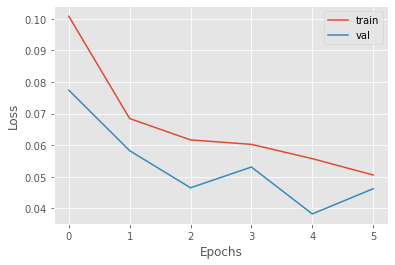

In [31]:
plt.style.use('ggplot')
plt.plot(loss_history['train'], label='train')
plt.plot(loss_history['val'], label='val')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.show()

# Prediction on validation set

We validate using our best weights from the training.

In [ ]:
# Load best weights from training
model.load_state_dict(best)
torch.save(model.state_dict(), "resnet18-50epochs.pth")
model.eval()
y_true = []
y_pred = []
for batch_idx, (data, gender, count, age, bag_label) in enumerate(tqdm(val_loader)):
    data, gender, count, age, bag_label = data.to(device), gender.to(device).float(), count.to(device).float(), age.to(device).float(), bag_label.float()
    # calculate loss and metrics
    with torch.no_grad():
        _, Y_hat, _ = model(data, gender, count, age)
        y_true.append(bag_label[0])
        y_pred.append(Y_hat.squeeze(0).detach().item())
val_balanced = balanced_accuracy_score(y_true, y_pred)
print("Validation Accuracy",val_balanced)


# Submission time
Time to send our predictions to the evaluation

In [ ]:
sub_dict = {"ID":[], "Predicted": [], "idx": []}
testset = LymphBags(test_dir, df_test, indices=range(len(df_test)), mode='test', transforms=val_tsfms)
test_loader = DataLoader(testset,batch_size=1, shuffle=True)
model.eval()
for batch_idx, (data, gender, count, age, idx) in enumerate(tqdm(test_loader)):
    data, gender, count, age = data.to(device), gender.to(device).float(), count.to(device).float(), age.to(device).float()
    _, y_hat, _ = model(data, gender, count, age)
    sub_dict["ID"].append(df_test.iloc[idx.item(),0])
    sub_dict['Predicted'].append(int(y_hat.item()))
    sub_dict['idx'].append(idx.item())

In [ ]:
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub.sort_values(by='idx', inplace=True)
df_sub.Predicted.hist()

In [ ]:
df_sub.to_csv('submission.csv')

In [ ]:
sub_dict = {"ID":df_test.ID.values, "Predicted": [int(df_test.iloc[i,4]>7) for i in range(len(df_test))]}
df_sub = pd.DataFrame.from_dict(sub_dict)
df_sub.head()

In [ ]:
df_sub.Predicted.hist()

In [ ]:
µ